In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval


In [2]:
WORKDIR='/home/lapy/PhD/Courses/MachineLearning/Project2/'
SRC = os.path.join(WORKDIR, 'gravitational_lens_ml/src')
DATA = os.path.join(WORKDIR,'')
RESULTS = os.path.join(WORKDIR, 'gravitational_lens_ml/results')
TRAIN = os.path.join(DATA, 'datapack2.0train/')
TEST = os.path.join(DATA, 'datapack2.0test/')

In [3]:
image_catalog = pd.read_csv(os.path.join(DATA, 'datapack2.0train/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [4]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [5]:
band = 'EUC_VIS'
def get_file_id(filename, band):
    return filename.replace('image%s-'%band,'').replace('.fits', '')
file_id_train = np.array([get_file_id(f, band) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
print(np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False))

[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [6]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
import tensorflow_transform as tft

In [7]:
def get_image_filename_from_id(id_, band, set_ = TRAIN):
    fname = os.path.join(set_, '{0}/image{0}-{1}.fits'.format(band, id_))
    return fname
def plot_all_bands_from_id(id_):
    fig = plt.figure(figsize=(20, 6))
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(aplpy.FITSFigure(data[i], figure=fig, subplot=(1,4,i+1)))
        fitsfigs[i].show_colorscale()
        fitsfigs[i].set_theme('preety')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()
    fig.tight_layout() 


INFO: Auto-setting vmin to -3.120e-12 [aplpy.core]
INFO: Auto-setting vmax to  1.754e-11 [aplpy.core]


INFO: Auto-setting vmin to -1.236e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.096e-09 [aplpy.core]


INFO: Auto-setting vmin to -8.179e-11 [aplpy.core]
INFO: Auto-setting vmax to  6.074e-10 [aplpy.core]


INFO: Auto-setting vmin to -1.043e-10 [aplpy.core]
INFO: Auto-setting vmax to  8.215e-10 [aplpy.core]


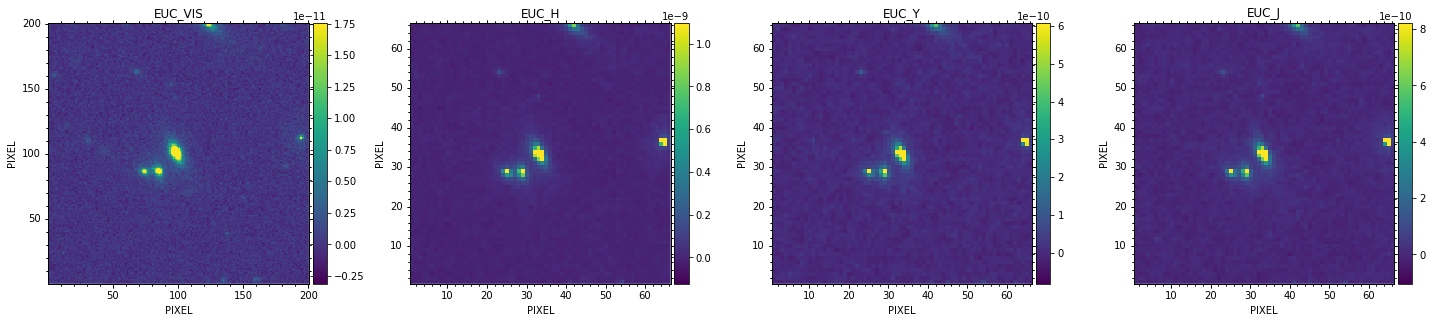

In [8]:
plot_all_bands_from_id(270610)

In [23]:
def pca(x, max_comp=3):
    """PCA on the design matrix x.

    Returns the new design matrix with vectors transformed to eigenspace of covariance matrix and the transformation matrix."""

    covariance_matrix = np.cov(x.T)
    eigenvals, eigenvect = np.linalg.eig(covariance_matrix)
    rank_eigenvals = sorted(eigenvals, reverse=True)
    val_vect_couples = {val:vect for val, vect in zip(eigenvals, eigenvect)}
    rank_eigenvects = [val_vect_couples[val] for val in rank_eigenvals]
    diagonal2original = np.vstack(rank_eigenvects)[:,:max_comp]
    new_x = x.dot(diagonal2original)
    print(diagonal2original)
    return new_x, rank_eigenvals

/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -1.290e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.218e-09 [aplpy.core]


/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -5.569e-11 [aplpy.core]
INFO: Auto-setting vmax to  3.780e-10 [aplpy.core]


/home/lapy/Apps/anaconda3/envs/tensorflow/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


INFO: Auto-setting vmin to -1.049e-10 [aplpy.core]
INFO: Auto-setting vmax to  9.173e-10 [aplpy.core]
(40000,)
(40000,)
(40000,)
[[ 0.33333462  0.94010749 -0.04877242 -0.05203073]
 [ 0.5278691  -0.24773309 -0.4364947  -0.68516779]
 [ 0.55201389 -0.155479    0.8182451  -0.03977315]
 [ 0.55274127 -0.17507859 -0.37090239  0.72543504]]
INFO: Auto-setting vmin to -2.468e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.256e-01 [aplpy.core]


INFO: Auto-setting vmin to -1.689e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.996e-02 [aplpy.core]


INFO: Auto-setting vmin to -6.162e-03 [aplpy.core]
INFO: Auto-setting vmax to  6.045e-03 [aplpy.core]


INFO: Auto-setting vmin to -5.815e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.864e-03 [aplpy.core]


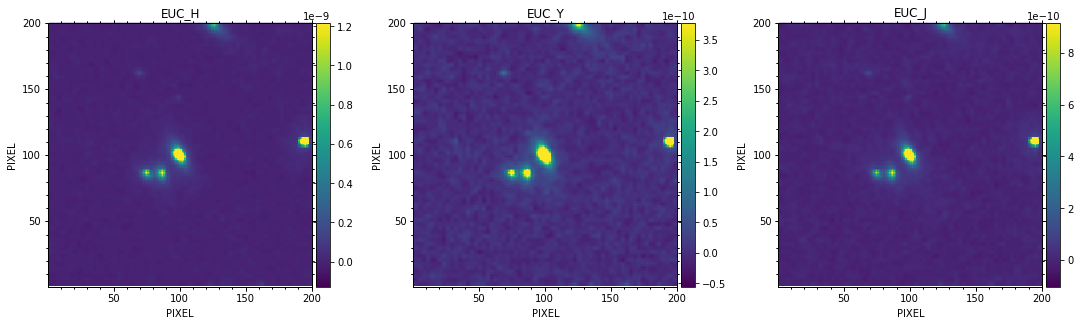

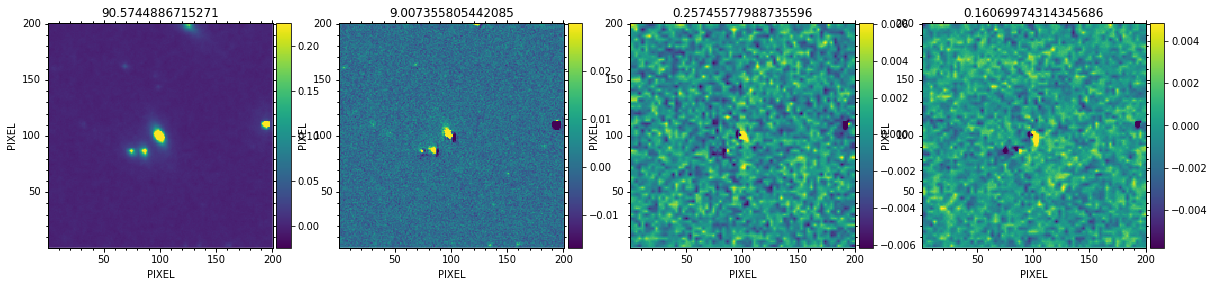

In [24]:
bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
bands_NIR = ['EUC_H', 'EUC_Y', 'EUC_J']
myid = 270610

data_NIR_reprojected_list = [] 
data_flatten_array = []

fitsfigs = []
fitsfigs2 = []

fig = plt.figure(figsize=(20, 6))

        
with fits.open(get_image_filename_from_id(myid, 'EUC_VIS')) as hdu_VIS:    
    data_VIS = hdu_VIS[0].data

for i, band in enumerate(bands_NIR):        
    with fits.open(get_image_filename_from_id(myid, band)) as hdu_NIR:
        data_NIR = hdu_NIR[0].data
        data_NIR_reprojected, data_NIR_footprint = reproject_interp(hdu_NIR[0], hdu_VIS[0].header)
        data_NIR_reprojected_list.append(data_NIR_reprojected)
            
    fitsfigs.append(aplpy.FITSFigure(data_NIR_reprojected_list[i], figure=fig, subplot=(1,4,i+1)))
    fitsfigs[i].show_colorscale()
    fitsfigs[i].set_theme('preety')
    fitsfigs[i].set_title(band)
    fitsfigs[i].add_colorbar()
        
fig.tight_layout()         
                
data_flatten_array.append(data_VIS.flatten())

for i, data_NIR in enumerate(data_NIR_reprojected_list):
    data_NIR[np.isnan(data_NIR)] = 0
    data_flatten_array.append(data_NIR.flatten())
    print(data_flatten_array[i].shape)
    
data_flatten_array = np.asarray(data_flatten_array)

for i in range(0, len(data_flatten_array)):
    data_flatten_array[i] = data_flatten_array[i]/(np.max(data_flatten_array[i]))

new_x, eigenvals = pca(data_flatten_array.T, 4)
fig2 = plt.figure(figsize=(20, 6))

for i in range(0, 4):
    fitsfigs2.append(aplpy.FITSFigure(new_x[:,i].reshape([200,200]), figure=fig2, subplot=(1,4,i+1)))
    fitsfigs2[i].show_colorscale()
    fitsfigs2[i].set_theme('preety')
    fitsfigs2[i].set_title(eigenvals[i]*100/np.sum(eigenvals))
    fitsfigs2[i].add_colorbar()


#mytensor = tf.convert_to_tensor(data_flatten, dtype = tf.float64)
#tmp = tft.pca(mytensor, 3, tf.float64)
#print(tmp.shape)
#matrix = tf.reshape(tmp[:,0], [200,200])
#print(matrix.shape)


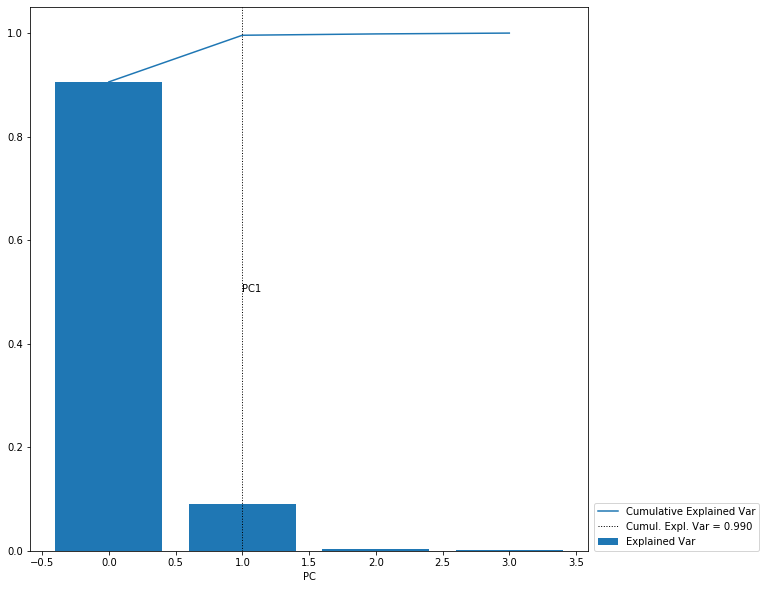

In [22]:
max_cumul_expl_var = 0.99
fig, ax = plt.subplots(1, figsize=(10, 10))
        
total_var = np.sum(eigenvals)
expl_var = eigenvals / total_var
cumulative_expl_var = np.cumsum(expl_var)
ax.bar(range(len(eigenvals)),
            expl_var,
            label='Explained Var')

ax.plot(range(len(eigenvals)),
            cumulative_expl_var,
            label='Cumulative Explained Var')

get_max_pct = np.arange(len(eigenvals))[cumulative_expl_var > max_cumul_expl_var][0]
ax.axvline(get_max_pct,
                c='k',
                ls=':',
                lw=1,
                label='Cumul. Expl. Var = %.3f' % max_cumul_expl_var)

ax.set_xlabel('PC')
ax.text(get_max_pct, 0.5,'PC%i'%get_max_pct)
ax.legend(loc = (1.01, 0))